In [250]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Part I - Read in the Data

In [251]:
path=r'C:\Users\aleci\Documents\Project 3 - Mortgage Origination Analysis\data\\'

file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

df_all=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])
df_all.shape

(2071611, 108)

In [284]:
df_all['LOAN_ID'].nunique()

104924

In [354]:
# derive a variable for 'bad'.  This variable will not be used in clustering, but it will be used to validate clusters. 
df_all['bad']=np.where(df_all['DLQ_STATUS'] >= 6, 1, 0)
df_bad=df_all.groupby('LOAN_ID')['bad'].sum().reset_index()
df_bad['bad']=np.where(df_bad['bad'] > 0, 1, 0)

In [355]:
df=df_all.drop_duplicates(subset='LOAN_ID', keep='first')

df=pd.merge(df.drop('bad', axis=1), df_bad, on="LOAN_ID", how='inner')

In [356]:
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

In [357]:
df['bad'].mean()

0.02353131790629408

In [358]:
df.head()

POOL_ID   LOAN_ID  ACT_PERIOD CHANNEL  \
0      NaN  98836743       12020       R   
1      NaN  98836744       12020       R   
2      NaN  98836805       12020       R   
3      NaN  98836862       12020       C   
4      NaN  98836951       12020       B   

                                              SELLER  \
0                                              Other   
1                                              Other   
2                                              Other   
3                           NationStar Mortgage, LLC   
4  United Shore Financial Services, LLC dba Unite...   

                                            SERVICER  MASTER_SERVICER  \
0                                              Other              NaN   
1                                              Other              NaN   
2                                              Other              NaN   
3                           NationStar Mortgage, LLC              NaN   
4  United Shore Financial Services, LLC dba Unite...              NaN   

   ORIG_RATE  CURR_RATE  ORIG_UPB  ...  BALLOON_INDICATOR  PLAN_NUMBER  \
0      3.625      3.625  207000.0  ...                NaN          NaN   
1      3.625      3.625  215000.0  ...                NaN          NaN   
2      3.250      3.250  210000.0  ...                NaN          NaN   
3      4.875      4.875  200000.0  ...                NaN          NaN   
4      4.183      4.183  109000.0  ...                NaN          NaN   

   FORBEARANCE_INDICATOR  HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR  \
0                      7                                                  N    
1                      7                                                  N    
2                      7                                                  N    
3                      7                                                  N    
4                      7                                                  N    

   DEAL_NAME  RE_PROCS_FLAG  ADR_TYPE  ADR_COUNT  ADR_UPB  bad  
0        NaN            NaN         7        NaN      NaN    0  
1        NaN            NaN         7        NaN      NaN    0  
2        NaN            NaN         7        NaN      NaN    1  
3        NaN            NaN         7        NaN      NaN    0  
4        NaN            NaN         7        NaN      NaN    0  

[5 rows x 109 columns]

# Part 2 - Determine what columns to use for generating clusters
* Kmeans is based on euclidean distance, so only numeric values can be used. 
* some character varibales can be transformed to numeric varlues. 

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 104923
Columns: 109 entries, POOL_ID to bad
dtypes: float64(75), int32(1), int64(11), object(22)
memory usage: 87.7+ MB


In [360]:
# get some descriptive statistics for numeric values 
# Transpose the output for a easier viewing
df.describe().T

count          mean            std           min  \
POOL_ID               0.0           NaN            NaN           NaN   
LOAN_ID          104924.0  9.917922e+07  197019.945107  9.883674e+07   
ACT_PERIOD       104924.0  2.306123e+04    8365.196512  1.202000e+04   
MASTER_SERVICER       0.0           NaN            NaN           NaN   
ORIG_RATE        104924.0  3.808843e+00       0.451864  2.375000e+00   
...                   ...           ...            ...           ...   
PLAN_NUMBER           0.0           NaN            NaN           NaN   
DEAL_NAME             0.0           NaN            NaN           NaN   
ADR_COUNT             0.0           NaN            NaN           NaN   
ADR_UPB               0.0           NaN            NaN           NaN   
bad              104924.0  2.353132e-02       0.151584  0.000000e+00   

                         25%          50%           75%         max  
POOL_ID                  NaN          NaN           NaN         NaN  
LOAN_ID          99009455.75  99180553.50  9.934903e+07  99520476.0  
ACT_PERIOD          12020.00     22020.00  3.202000e+04     32020.0  
MASTER_SERVICER          NaN          NaN           NaN         NaN  
ORIG_RATE               3.50         3.75  3.999000e+00         6.5  
...                      ...          ...           ...         ...  
PLAN_NUMBER              NaN          NaN           NaN         NaN  
DEAL_NAME                NaN          NaN           NaN         NaN  
ADR_COUNT                NaN          NaN           NaN         NaN  
ADR_UPB                  NaN          NaN           NaN         NaN  
bad                     0.00         0.00  0.000000e+00         1.0  

[87 rows x 8 columns]

In [361]:
# check null values to see whether any cleaning needs to be done
df.isnull().sum()

POOL_ID          104924
LOAN_ID               0
ACT_PERIOD            0
CHANNEL               0
SELLER                0
                  ...  
RE_PROCS_FLAG    104924
ADR_TYPE              0
ADR_COUNT        104924
ADR_UPB          104924
bad                   0
Length: 109, dtype: int64

In [362]:
df['PROP'].value_counts()

SF    60598
PU    32909
CO    10748
MH      647
CP       22
Name: PROP, dtype: int64

In [363]:
# encode loan purpose
df['prop']=np.where(df['PROP'].isin(['MH', 'CP']), 'other', df['PROP'])

df=pd.get_dummies(df, columns=['PURPOSE'])
df=pd.get_dummies(df, columns=['prop'])

In [364]:
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPURCHASES_MAKE_

In [365]:
# Since Kmeans is based on Euclidean distance, it only uses numeric values.
# Therefore, we only keep the numeric values
# Columns such as POOL_ID and LOAN_ID have no meaning in computation, so they are not included either.
# We keep LOAN_ID as a merging key to be used later.
# Decomissioned has the the same value for all rows, so it is dropped. 
# We delete Current Rate and current UPB. 
# OLTV asnd OCLTV are too close to each other. We retain OLTV only. 

df['loan_term']=np.where(df['ORIG_TERM']==360, 2, 
                              np.where(df['ORIG_TERM']==180, 1, 0))

# excclude those borrowers with no valid FICO
df=df[df['CSCORE_B'] > 300]


# split the sample
df['random']=np.random.uniform(0, 1, len(df['LOAN_ID']))
df['seg']=np.where(df['random'] <= 0.7, 'mod', 'val')

Xlist=[
'ORIG_UPB',
'CSCORE_B',
'loan_term',
'OLTV',
'DTI',
'NO_UNITS',
'MI_PCT',
'PURPOSE_C',
'PURPOSE_P',
'PURPOSE_R',
'prop_CO',
'prop_PU',
'prop_SF',
'prop_other'
]

Xylist=[
'ORIG_UPB',
'CSCORE_B',
'loan_term',
'OLTV',
'DTI',
'NO_UNITS',
'MI_PCT',
'PURPOSE_C',
'PURPOSE_P',
'PURPOSE_R',
'prop_CO',
'prop_PU',
'prop_SF',
'prop_other',
'bad'  
]


modelsample=df[df['seg']=='mod'][Xylist].fillna(0)
valsample=df[df['seg']=='val'][Xylist].fillna(0)

#### All variables need to be standardized before running clustering

In [366]:
modelsample[Xlist].describe().T

count           mean            std      min       25%  \
ORIG_UPB    73363.0  253170.412878  123388.409694  10000.0  157000.0   
CSCORE_B    73363.0     756.793206      42.374295    620.0     729.0   
loan_term   73363.0       1.632212       0.672236      0.0       1.0   
OLTV        73363.0      73.924649      16.275997      7.0      65.0   
DTI         73363.0      34.186102       9.577299      0.0      27.0   
NO_UNITS    73363.0       1.010687       0.135835      1.0       1.0   
MI_PCT      73363.0       6.932623      11.709561      0.0       0.0   
PURPOSE_C   73363.0       0.254992       0.435860      0.0       0.0   
PURPOSE_P   73363.0       0.356488       0.478965      0.0       0.0   
PURPOSE_R   73363.0       0.388520       0.487417      0.0       0.0   
prop_CO     73363.0       0.102422       0.303205      0.0       0.0   
prop_PU     73363.0       0.312773       0.463626      0.0       0.0   
prop_SF     73363.0       0.578330       0.493830      0.0       0.0   
prop_other  73363.0       0.006475       0.080205      0.0       0.0   

                 50%       75%       max  
ORIG_UPB    236000.0  334000.0  800000.0  
CSCORE_B       766.0     791.0     835.0  
loan_term        2.0       2.0       2.0  
OLTV            76.0      85.0      97.0  
DTI             35.0      42.0      50.0  
NO_UNITS         1.0       1.0       4.0  
MI_PCT           0.0      12.0      35.0  
PURPOSE_C        0.0       1.0       1.0  
PURPOSE_P        0.0       1.0       1.0  
PURPOSE_R        0.0       1.0       1.0  
prop_CO          0.0       0.0       1.0  
prop_PU          0.0       1.0       1.0  
prop_SF          1.0       1.0       1.0  
prop_other       0.0       0.0       1.0

In [367]:
# standardize the variables
# It is very important to make a copy of the modeling sample and use the copy to calculate mean and std. 

# standardize the variable
modsamp=modelsample.copy()

def standardize(x, samp):
    x_mean=modsamp[x].mean()
    x_std=modsamp[x].std()
    
    x_standardized=(samp[x]-x_mean)/x_std
    return x_standardized

for item in Xlist:
    modelsample[item]=standardize(item, modelsample)
    valsample[item]=standardize(item, valsample)
    
# normalize the variable between 0 and 1  
modsamp2=modelsample.copy()

def scaler(x, samp):
    x_max=modsamp2[x].max()
    x_min=modsamp2[x].min()
    
    x_standardized=(samp[x]-x_min)/(x_max-x_min)
    return x_standardized

for item in Xlist:
    modelsample[item]=scaler(item, modelsample)
    valsample[item]=scaler(item, valsample)

In [368]:
modelsample[Xlist].describe().T

count      mean       std  min       25%       50%       75%  \
ORIG_UPB    73363.0  0.307811  0.156188  0.0  0.186076  0.286076  0.410127   
CSCORE_B    73363.0  0.636247  0.197090  0.0  0.506977  0.679070  0.795349   
loan_term   73363.0  0.816106  0.336118  0.0  0.500000  1.000000  1.000000   
OLTV        73363.0  0.743607  0.180844  0.0  0.644444  0.766667  0.866667   
DTI         73363.0  0.683722  0.191546  0.0  0.540000  0.700000  0.840000   
NO_UNITS    73363.0  0.003562  0.045278  0.0  0.000000  0.000000  0.000000   
MI_PCT      73363.0  0.198075  0.334559  0.0  0.000000  0.000000  0.342857   
PURPOSE_C   73363.0  0.254992  0.435860  0.0  0.000000  0.000000  1.000000   
PURPOSE_P   73363.0  0.356488  0.478965  0.0  0.000000  0.000000  1.000000   
PURPOSE_R   73363.0  0.388520  0.487417  0.0  0.000000  0.000000  1.000000   
prop_CO     73363.0  0.102422  0.303205  0.0  0.000000  0.000000  0.000000   
prop_PU     73363.0  0.312773  0.463626  0.0  0.000000  0.000000  1.000000   
prop_SF     73363.0  0.578330  0.493830  0.0  0.000000  1.000000  1.000000   
prop_other  73363.0  0.006475  0.080205  0.0  0.000000  0.000000  0.000000   

            max  
ORIG_UPB    1.0  
CSCORE_B    1.0  
loan_term   1.0  
OLTV        1.0  
DTI         1.0  
NO_UNITS    1.0  
MI_PCT      1.0  
PURPOSE_C   1.0  
PURPOSE_P   1.0  
PURPOSE_R   1.0  
prop_CO     1.0  
prop_PU     1.0  
prop_SF     1.0  
prop_other  1.0

In [369]:
valsample[Xlist].describe().T

count      mean       std       min       25%       50%  \
ORIG_UPB    31510.0  0.310253  0.158005  0.002532  0.184810  0.289873   
CSCORE_B    31510.0  0.635771  0.197678  0.000000  0.502326  0.679070   
loan_term   31510.0  0.816043  0.336529  0.000000  0.500000  1.000000   
OLTV        31510.0  0.743722  0.180039  0.011111  0.644444  0.766667   
DTI         31510.0  0.682012  0.191717  0.020000  0.540000  0.700000   
NO_UNITS    31510.0  0.003703  0.046079  0.000000  0.000000  0.000000   
MI_PCT      31510.0  0.196865  0.334206  0.000000  0.000000  0.000000   
PURPOSE_C   31510.0  0.252110  0.434231  0.000000  0.000000  0.000000   
PURPOSE_P   31510.0  0.356268  0.478903  0.000000  0.000000  0.000000   
PURPOSE_R   31510.0  0.391622  0.488121  0.000000  0.000000  0.000000   
prop_CO     31510.0  0.102444  0.303236  0.000000  0.000000  0.000000   
prop_PU     31510.0  0.315900  0.464881  0.000000  0.000000  0.000000   
prop_SF     31510.0  0.575500  0.494275  0.000000  0.000000  1.000000   
prop_other  31510.0  0.006157  0.078224  0.000000  0.000000  0.000000   

                 75%       max  
ORIG_UPB    0.415190  0.956962  
CSCORE_B    0.795349  0.976744  
loan_term   1.000000  1.000000  
OLTV        0.866667  1.000000  
DTI         0.840000  1.000000  
NO_UNITS    0.000000  1.000000  
MI_PCT      0.342857  1.000000  
PURPOSE_C   1.000000  1.000000  
PURPOSE_P   1.000000  1.000000  
PURPOSE_R   1.000000  1.000000  
prop_CO     0.000000  1.000000  
prop_PU     1.000000  1.000000  
prop_SF     1.000000  1.000000  
prop_other  0.000000  1.000000

In [370]:
print("model sample avg bad: {}".format(modelsample['bad'].mean()))
print("validation sample avg bad: {}".format(valsample['bad'].mean()))
print("model sample total bad: {}".format(modelsample['bad'].sum()))

model sample avg bad: 0.023704046999168518
validation sample avg bad: 0.02316724849254205
model sample total bad: 1739


In [371]:
# as our sample exceeds 2mm rows, it will take too long to process for some analysis. 
# We make a 2% sample for subsequent analyses. 

modelsample_good=modelsample[modelsample['bad']==0]
shrinksample=pd.concat([modelsample_good.sample(1702), modelsample[modelsample['bad']==1]])
shrinksample.shape

(3441, 15)

In [372]:
shrinksample.describe().T

count      mean       std       min       25%       50%  \
ORIG_UPB    3441.0  0.319156  0.158041  0.016456  0.194937  0.300000   
CSCORE_B    3441.0  0.569448  0.215351  0.000000  0.409302  0.600000   
loan_term   3441.0  0.864429  0.296543  0.000000  1.000000  1.000000   
OLTV        3441.0  0.777897  0.171783  0.077778  0.688889  0.811111   
DTI         3441.0  0.735077  0.184224  0.020000  0.600000  0.760000   
NO_UNITS    3441.0  0.003778  0.050373  0.000000  0.000000  0.000000   
MI_PCT      3441.0  0.253473  0.360307  0.000000  0.000000  0.000000   
PURPOSE_C   3441.0  0.248184  0.432022  0.000000  0.000000  0.000000   
PURPOSE_P   3441.0  0.392618  0.488404  0.000000  0.000000  0.000000   
PURPOSE_R   3441.0  0.359198  0.479835  0.000000  0.000000  0.000000   
prop_CO     3441.0  0.101133  0.301549  0.000000  0.000000  0.000000   
prop_PU     3441.0  0.348155  0.476455  0.000000  0.000000  0.000000   
prop_SF     3441.0  0.546934  0.497865  0.000000  0.000000  1.000000   
prop_other  3441.0  0.003778  0.061358  0.000000  0.000000  0.000000   
bad         3441.0  0.505376  0.500044  0.000000  0.000000  1.000000   

                 75%       max  
ORIG_UPB    0.422785  0.956962  
CSCORE_B    0.748837  0.967442  
loan_term   1.000000  1.000000  
OLTV        0.922222  1.000000  
DTI         0.880000  1.000000  
NO_UNITS    0.000000  1.000000  
MI_PCT      0.714286  1.000000  
PURPOSE_C   0.000000  1.000000  
PURPOSE_P   1.000000  1.000000  
PURPOSE_R   1.000000  1.000000  
prop_CO     0.000000  1.000000  
prop_PU     1.000000  1.000000  
prop_SF     1.000000  1.000000  
prop_other  0.000000  1.000000  
bad         1.000000  1.000000

* We want to see whether 'bad' can be easily separated from 'good' in variable distribution
* If so, we do not need to go on. 

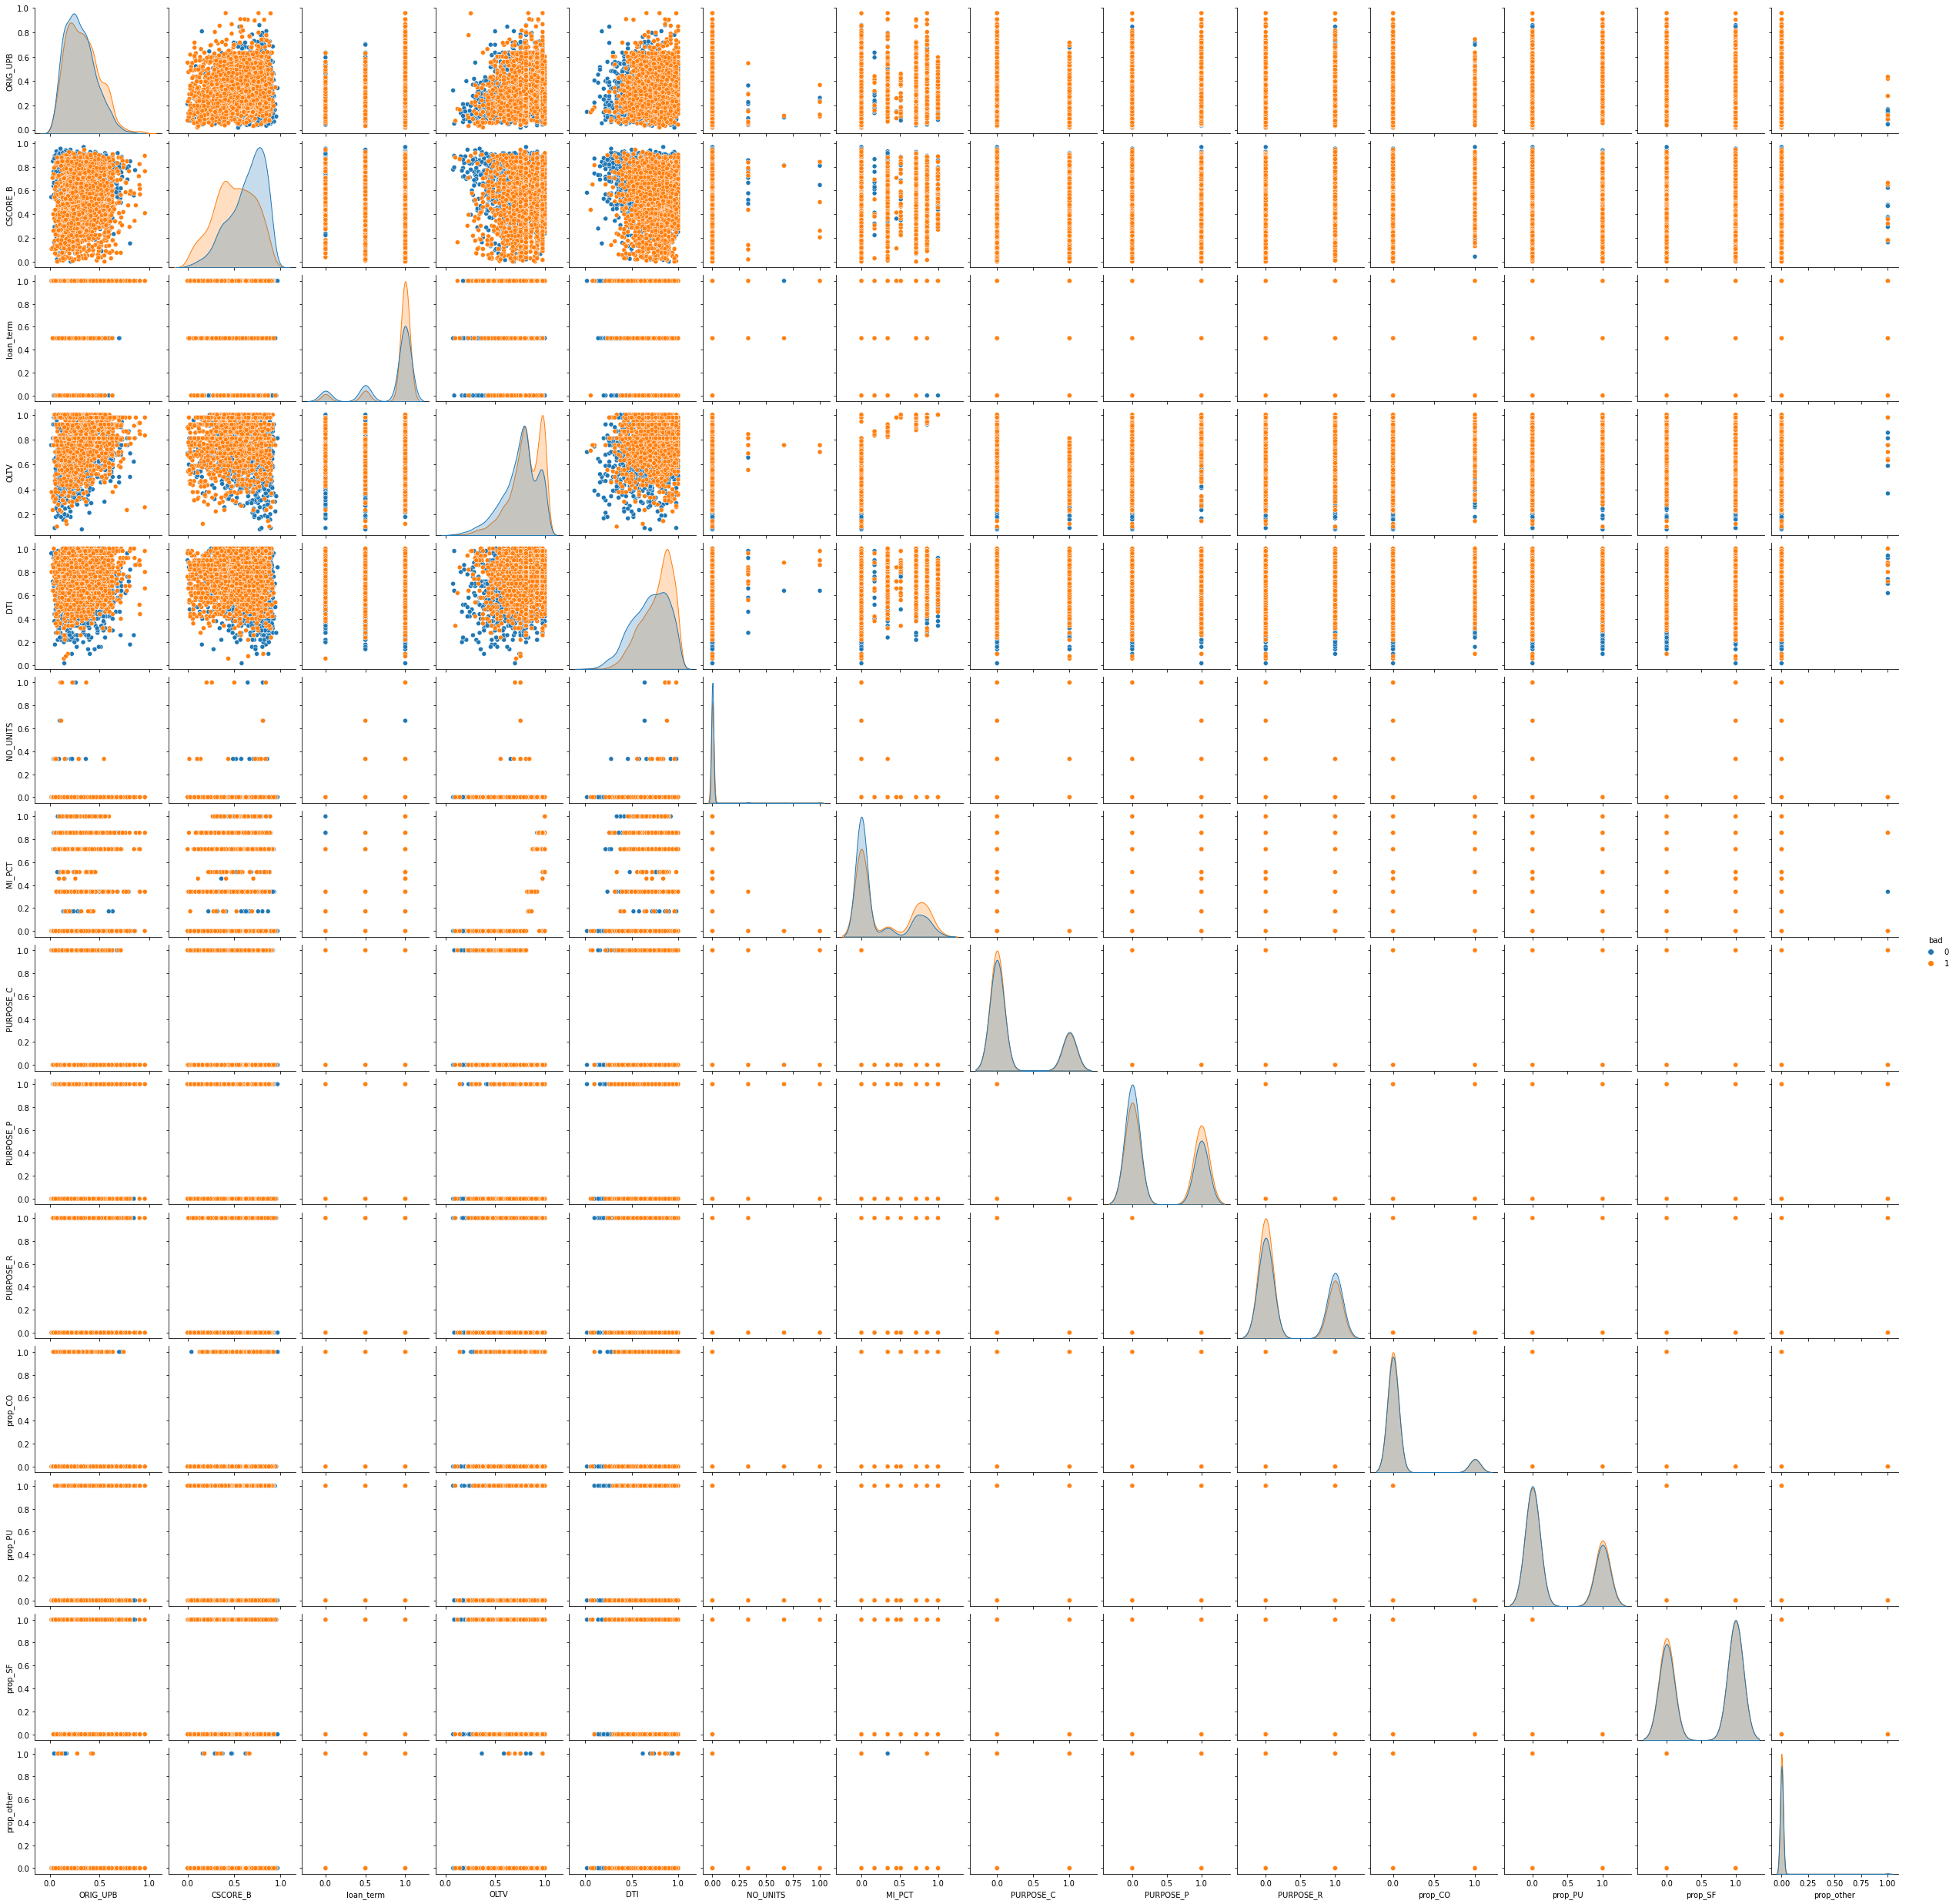

In [373]:
sns.pairplot(shrinksample, hue='bad')

#### determine optimal number of clusters

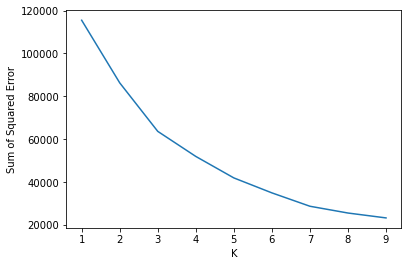

In [374]:
# deterine k value
from sklearn.cluster import KMeans

sse=[]

for k in range(1, 10):
    model=KMeans(n_clusters=k)
    model.fit(modelsample.drop('bad', axis=1))
    sse.append(model.inertia_)
    
x=range(1, 10)
y=sse

plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(x, y)

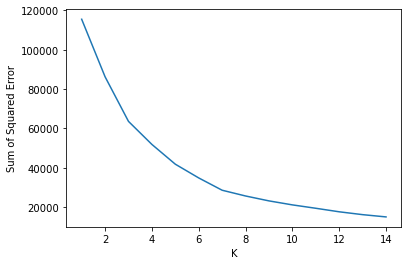

In [375]:
# deterine k value
from sklearn.cluster import KMeans

sse=[]

for k in range(1, 15):
    model=KMeans(n_clusters=k)
    model.fit(modelsample.drop('bad', axis=1))
    sse.append(model.inertia_)
    
x=range(1, 15)
y=sse

plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(x, y)

* We need to find a good elbow point in the above graph.
* It looks like SSE no longer drops significantly from 7 to 8. 

#### validate the performance by each cluster
* We want to find whether one or multiple clusters show much higher or lower risk.

In [376]:
model=KMeans(n_clusters=7)
model.fit(modelsample.drop('bad', axis=1))

y_pred=model.predict(modelsample.drop('bad', axis=1))

modelsample['cluster']=y_pred

modelsample_sum=modelsample.groupby('cluster')['bad'].agg(['count', 'sum', 'mean'])
modelsample_sum=modelsample.groupby('cluster')['bad'].agg(model_count='count',
                                                          model_sum='sum',
                                                          model_mean='mean')
modelsample_sum['model_count_pct']=modelsample_sum['model_count']/(modelsample_sum['model_count'].sum())


# Check on the validation sample
y_pred_val=model.predict(valsample.drop('bad', axis=1))

valsample['cluster']=y_pred_val

valsample_sum=valsample.groupby('cluster')['bad'].agg(['count', 'sum', 'mean'])
valsample_sum=valsample.groupby('cluster')['bad'].agg(val_count='count',
                                                      val_sum='sum',
                                                      val_mean='mean')
valsample_sum['val_count_pct']=valsample_sum['val_count']/(valsample_sum['val_count'].sum())


# merge the two summaries
mod_val_sum=pd.merge(modelsample_sum, valsample_sum, on='cluster', how='outer').reset_index()
mod_val_sum

cluster  model_count  model_sum  model_mean  model_count_pct  val_count  \
0        0         4994        120    0.024029         0.068072       2102   
1        1        16610        304    0.018302         0.226408       7150   
2        2         8803        304    0.034534         0.119992       3827   
3        3        13854        374    0.026996         0.188842       5874   
4        4         7514        174    0.023157         0.102422       3228   
5        5        12421        264    0.021254         0.169309       5298   
6        6         9167        199    0.021708         0.124954       4031   

   val_sum  val_mean  val_count_pct  
0       47  0.022360       0.066709  
1      124  0.017343       0.226912  
2      118  0.030834       0.121454  
3      164  0.027920       0.186417  
4       78  0.024164       0.102444  
5      101  0.019064       0.168137  
6       98  0.024312       0.127928

C:\Users\aleci\AppData\Local\Temp/ipykernel_1844/1068983731.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()])


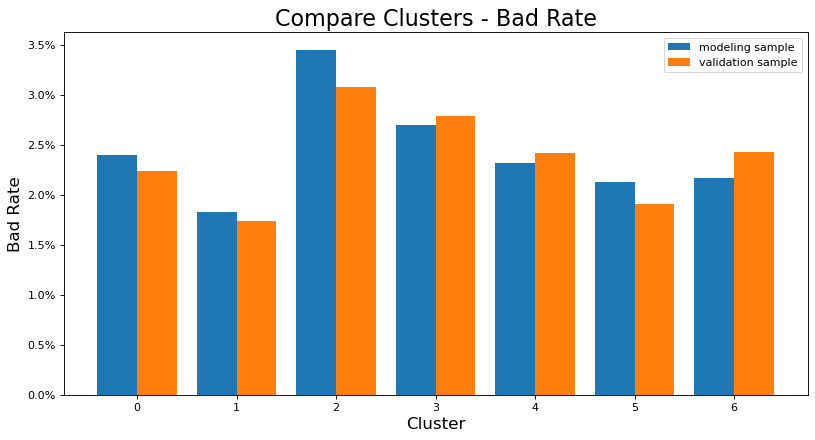

In [377]:
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick  # for formating y axis

figure(figsize=(12, 6), dpi=80)

clusters=[0, 1, 2, 3, 4, 5, 6]
x_axis=np.arange(len(clusters))

plt.bar(x_axis -0.2, mod_val_sum['model_mean'], width=0.4, label = 'modeling sample')
plt.bar(x_axis +0.2, mod_val_sum['val_mean'], width=0.4, label = 'validation sample')
plt.xticks(x_axis, clusters)
plt.xlabel("Cluster", fontsize=15)
plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()]) 
plt.ylabel("Bad Rate", fontsize=15, )
# plt.ylim([20, 80])  # we set this range from 20 in order to accentuate the difference between two periods
plt.title("Compare Clusters - Bad Rate", fontsize=20)
plt.legend(loc='best')
plt.show()

C:\Users\aleci\AppData\Local\Temp/ipykernel_1844/302107572.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()])


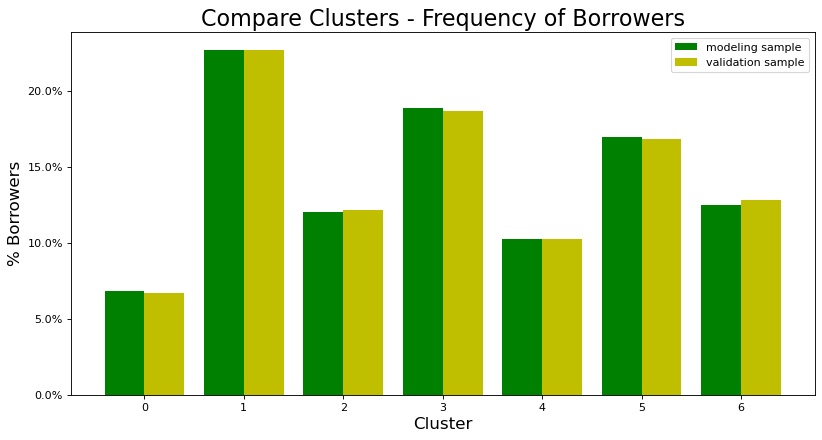

In [378]:
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick  # for formating y axis

figure(figsize=(12, 6), dpi=80)

clusters=[0, 1, 2, 3, 4, 5, 6]
x_axis=np.arange(len(clusters))

plt.bar(x_axis -0.2, mod_val_sum['model_count_pct'], width=0.4, color='g', label = 'modeling sample')
plt.bar(x_axis +0.2, mod_val_sum['val_count_pct'], width=0.4, color='y', label = 'validation sample')
plt.xticks(x_axis, clusters)
plt.xlabel("Cluster", fontsize=15)
plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()]) 
plt.ylabel("% Borrowers", fontsize=15, )
# plt.ylim([20, 80])  # we set this range from 20 in order to accentuate the difference between two periods
plt.title("Compare Clusters - Frequency of Borrowers", fontsize=20)
plt.legend(loc='best')
plt.show()

# Use clusters to assess performance 
* Even though Kmeans clustering is a method of unsupervised learning, we can use it to see whether clusters show any difference in predicting a target.

C:\Users\aleci\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ORIG_UPB', ylabel='CSCORE_B'>

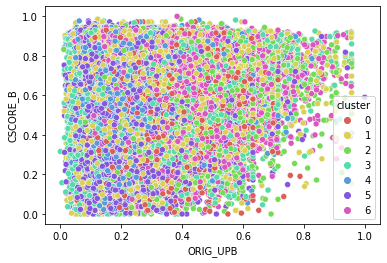

In [379]:
# Visualize clusters on variables
sns.scatterplot(modelsample['ORIG_UPB'], modelsample['CSCORE_B'], hue=modelsample['cluster'], palette=sns.color_palette('hls', 7))

C:\Users\aleci\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ORIG_UPB', ylabel='DTI'>

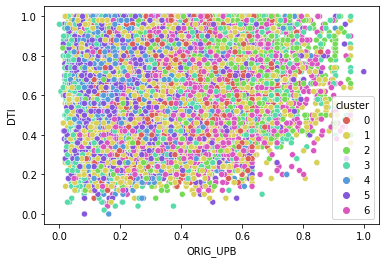

In [380]:
# Visualize clusters on variables
sns.scatterplot(modelsample['ORIG_UPB'], modelsample['DTI'], hue=modelsample['cluster'], palette=sns.color_palette('hls', 7))

C:\Users\aleci\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DTI', ylabel='CSCORE_B'>

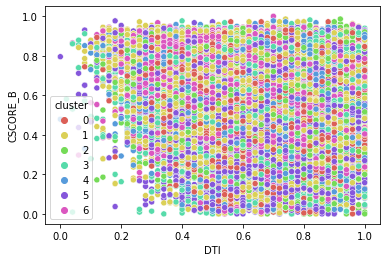

In [381]:
sns.scatterplot(modelsample['DTI'], modelsample['CSCORE_B'], hue=modelsample['cluster'], palette=sns.color_palette('hls', 7))

C:\Users\aleci\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DTI', ylabel='OLTV'>

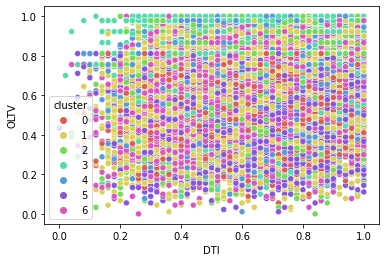

In [382]:
sns.scatterplot(modelsample['DTI'], modelsample['OLTV'], hue=modelsample['cluster'], palette=sns.color_palette('hls', 7))

C:\Users\aleci\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='OLTV', ylabel='ORIG_UPB'>

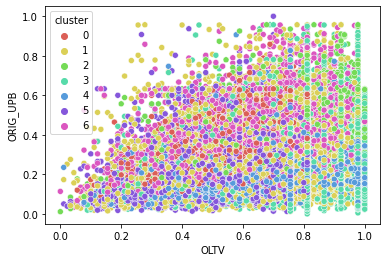

In [383]:
sns.scatterplot(modelsample['OLTV'], modelsample['ORIG_UPB'], hue=modelsample['cluster'], palette=sns.color_palette('hls', 7))

#### We want to see whether the clusters can be easily seen in a 2-variable combition

(14662, 16)


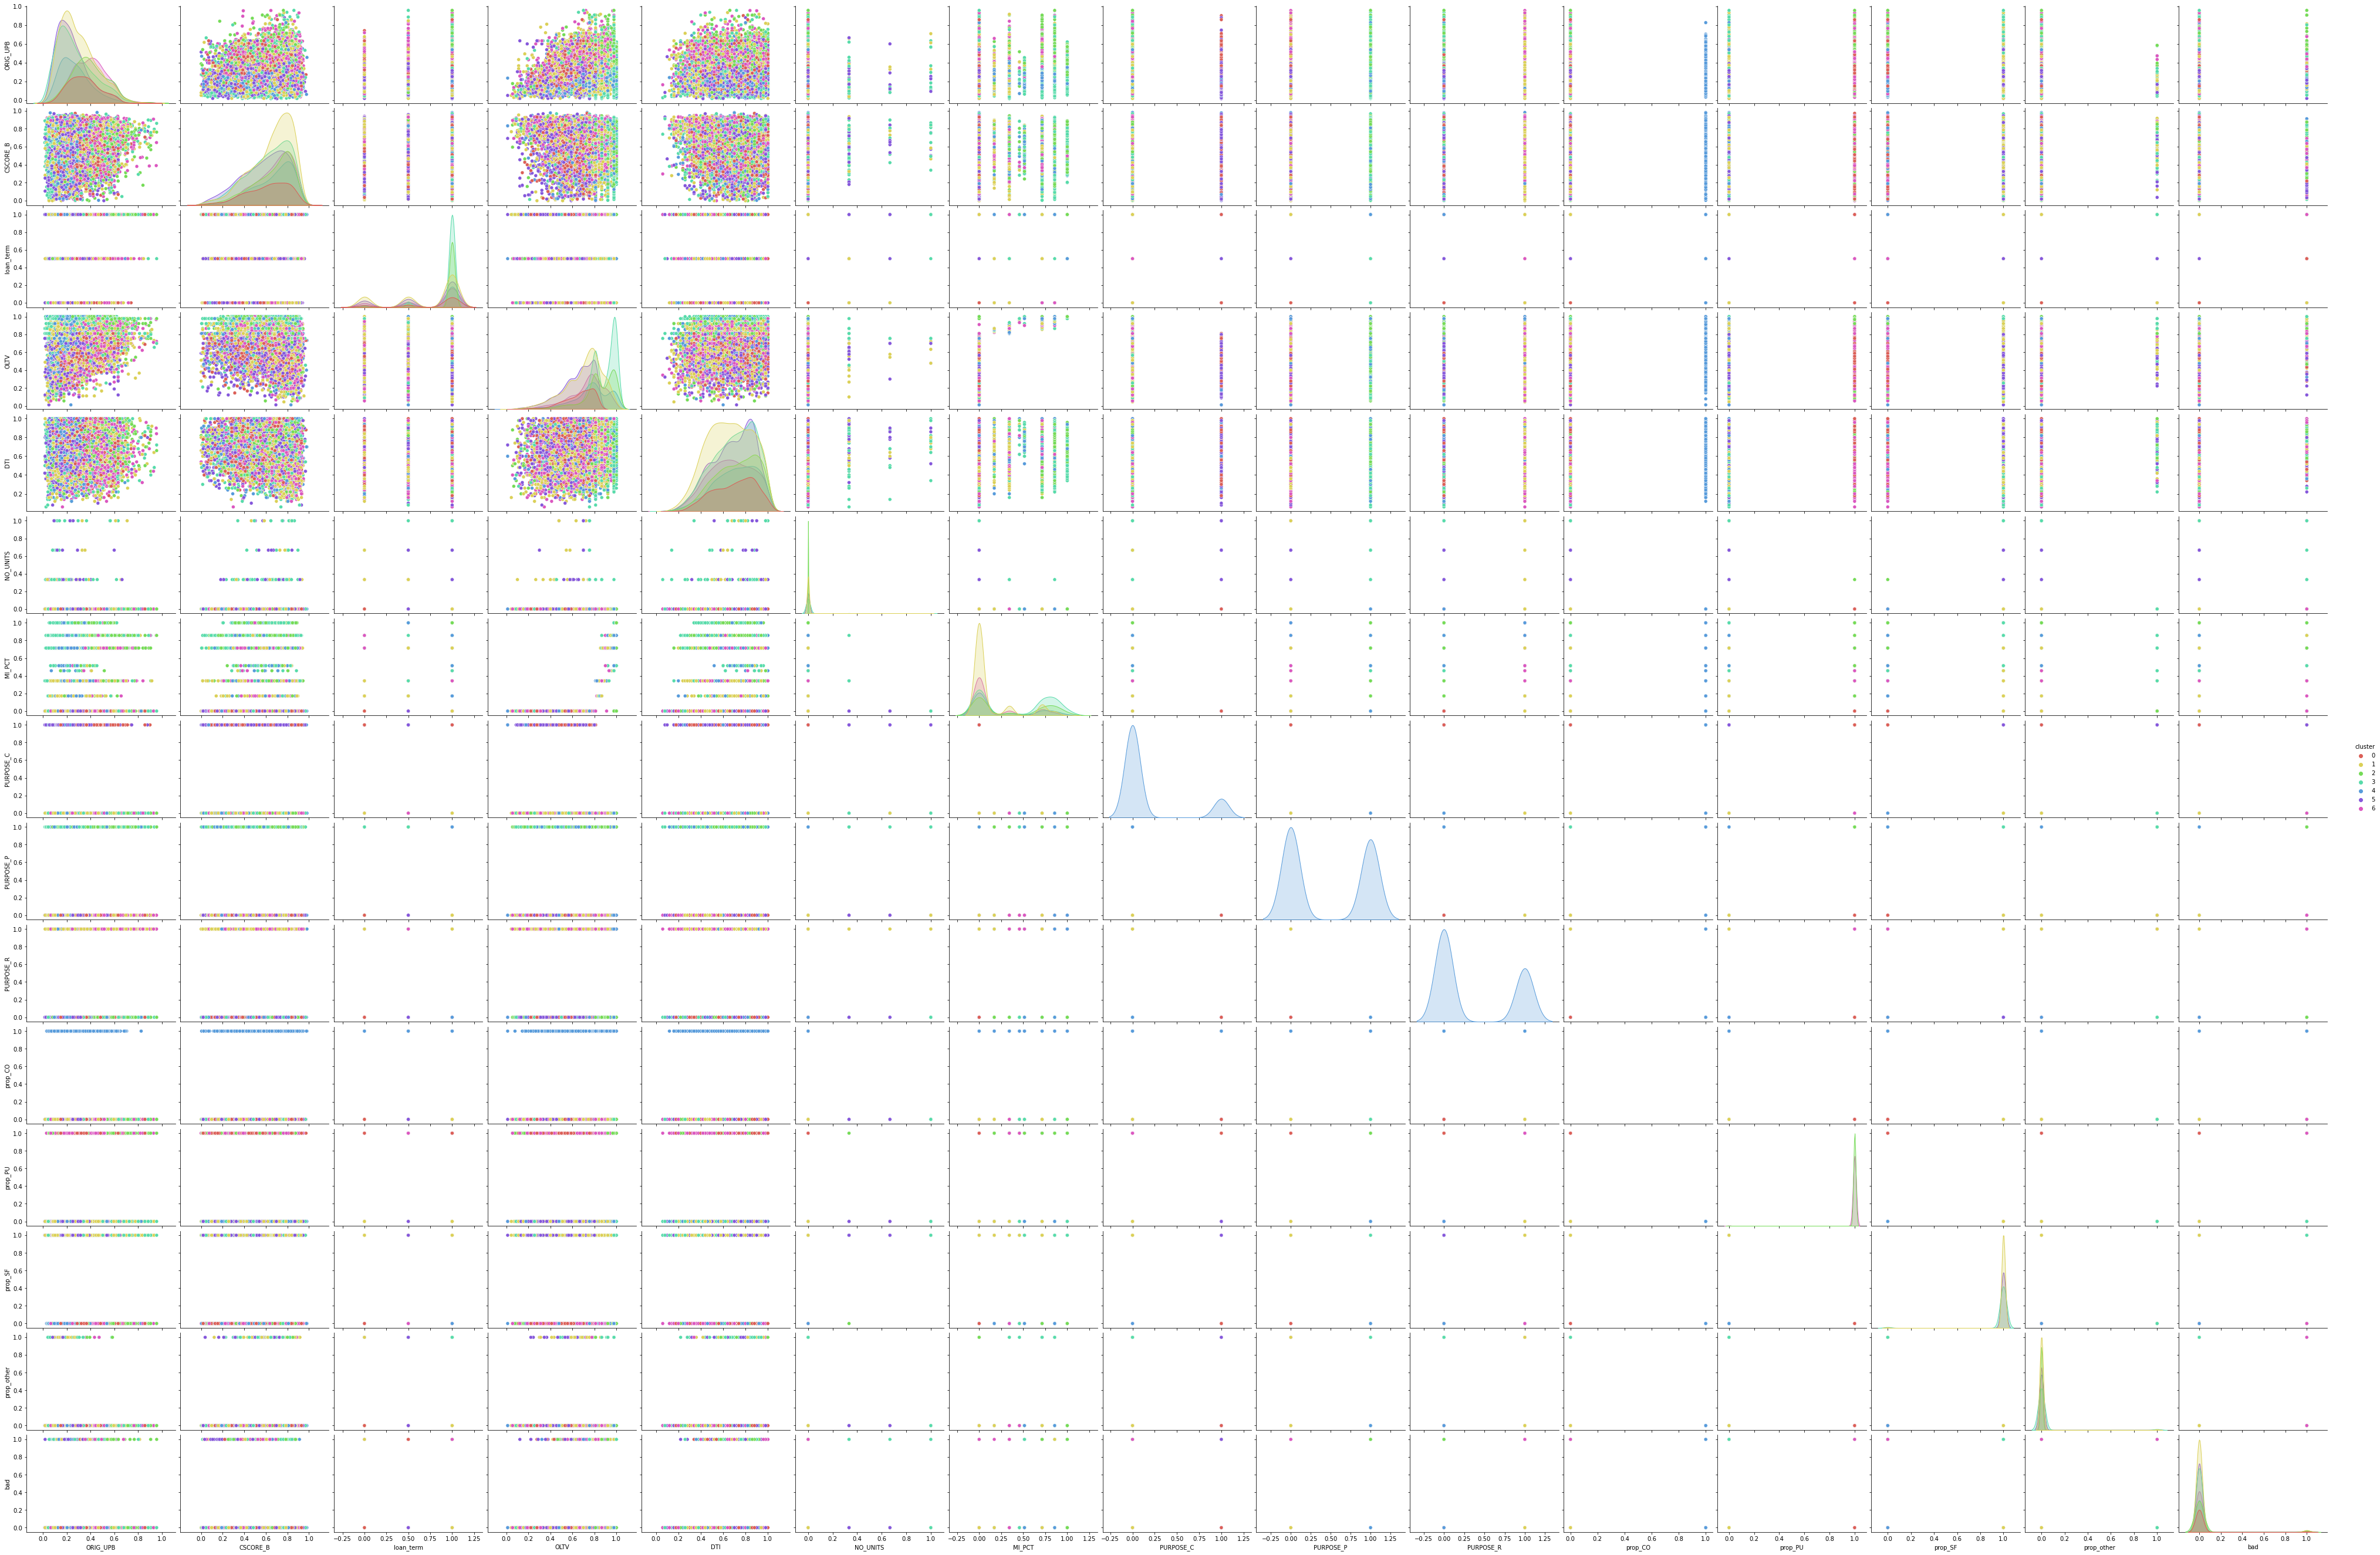

In [385]:
# as the following program is likely to take a long time to run, we make a smaller sample to do it. 
smallsample=modelsample[np.random.uniform(0, 1, len(modelsample['ORIG_UPB'])) < 0.2]
print(smallsample.shape)

sns.pairplot(smallsample, hue='cluster', palette=sns.color_palette('hls', 7), aspect=1.5)

# save the graph to a folder. 
plt.savefig(path+'project4_segmentation.png', dpi=300)

## Conclusion

The clustering analysis segmented the mortgage portfolio into 7 groups with distinct risk profiles, identifying both high and low-risk clusters. High-risk clusters highlight borrower profiles that may need closer monitoring, while low-risk clusters indicate stability. Validation results confirm the model’s reliability.

This segmentation enables:

* Targeted resource allocation,
* Risk-based loan terms and pricing,
* Early intervention for high-risk loans.

This model provides valuable insights for strategic, data-driven portfolio management and can enhance predictive modeling for improved risk forecasting.